### PCA

In [3]:
def pca(Y, N):
    """
    Perform Principal Component Analysis (PCA) on the input matrix Y.

    Args:
        Y (torch.Tensor): Input data matrix of shape (M, L), where M is the number of spectral bands, and L is the number of samples.
        N (int): Number of principal components to retain.

    Returns:
        Y_red (torch.Tensor): Reduced dimensionality data matrix of shape (N-1, L).
        C (torch.Tensor): Eigenvector matrix.
        d (torch.Tensor): Mean vector used for centering.
    """
    assert Y.ndim == 2, "Input data Y must be a 2D tensor."
    
    d = torch.mean(Y, dim=1, keepdim=True)  # Compute the mean for each band (row)
    Y_cen = Y - d  # Center the data
    covariance_matrix = Y_cen @ Y_cen.T  # Compute the covariance matrix
    
    # Eigen decomposition (eigh is used for symmetric matrices)
    eigenvalues, eigenvectors = torch.linalg.eigh(covariance_matrix)
    
    # Select the top N-1 eigenvectors corresponding to the largest eigenvalues
    idx = torch.argsort(eigenvalues, descending=True)
    C = eigenvectors[:, idx][:, :N-1]  # Eigenvector matrix (top N-1)
    
    # Project the data onto the reduced eigenbasis
    Y_red = torch.pinverse(C) @ Y_cen
    
    return Y_red, C, d

### SVMAX

In [11]:
def SVMAX(Y, N):
    """
    Perform Successive Volume Maximization (SVMAX) for endmember extraction.

    Args:
        Y (torch.Tensor): Input data matrix of shape (M, L), where M is the number of spectral bands, and L is the number of samples.
        N (int): Number of endmembers to extract.

    Returns:
        A_est (torch.Tensor): Estimated endmember matrix of shape (M, N).
    """
    # PCA for dimensionality reduction
    X, C, d = pca(Y, N)
    
    # Augment X with a row of ones
    X_aug = torch.cat((X, torch.ones((1, X.shape[1]), device=X.device)), dim=0)
    
    A_est = []
    P = torch.eye(X.shape[0] + 1, device=X.device)  # Projection matrix to include the augmented X_bar
    
    for i in range(N):
        # Find the index of the column of X_bar that maximizes the projection
        _, idx_i = torch.max(torch.sum((P @ X_aug) ** 2, dim=0), dim=0)
        
        # Append the selected endmember vector to A_est
        A_est.append(X[:, idx_i].unsqueeze(1))
        
        # Form the F matrix for updating P
        A_cat = torch.cat(A_est, dim=1)  # Concatenate selected endmembers
        ones_row = torch.ones((1, A_cat.shape[1]), device=X.device)
        F = torch.cat([A_cat, ones_row], dim=0)
        
        # Update projection matrix P
        P = torch.eye(P.shape[0], device=X.device) - F @ torch.pinverse(F)
    
    A_est = torch.cat(A_est, dim=1)
    
    # Project back to the original space and add the mean
    A_est = C @ A_est + d
    return A_est

### SPA

In [12]:
def SPA(Y, N):
    """
    Perform Successive Projection Algorithm (SPA) for endmember extraction.

    Args:
        Y (torch.Tensor): Input data matrix of shape (M, L), where M is the number of spectral bands, and L is the number of samples.
        N (int): Number of endmembers to extract.

    Returns:
        A_init (torch.Tensor): Estimated endmember matrix of shape (M, N).
    """
    M = Y.shape[0]  # Number of spectral bands
    P = torch.eye(M, device=Y.device)  # Initialize the projection matrix
    A_init = torch.zeros(M, N, device=Y.device)  # Endmember matrix
    Y = Y.float()  # Ensure the input is float for better numerical stability
    
    idx = []
    for i in range(N):
        # Find the index of the column that maximizes the projection
        _, idx_i = torch.max(torch.sum((P @ Y) ** 2, dim=0), dim=0)
        idx.append(idx_i.item())
        
        # Extract the selected endmember
        A_init[:, i] = Y[:, idx_i]
        
        # Update the projection matrix using the selected column
        P_y = P @ Y[:, idx_i]
        P -= torch.outer(P_y, P_y) / torch.norm(P_y, p=2) ** 2

    return A_init

## Testing

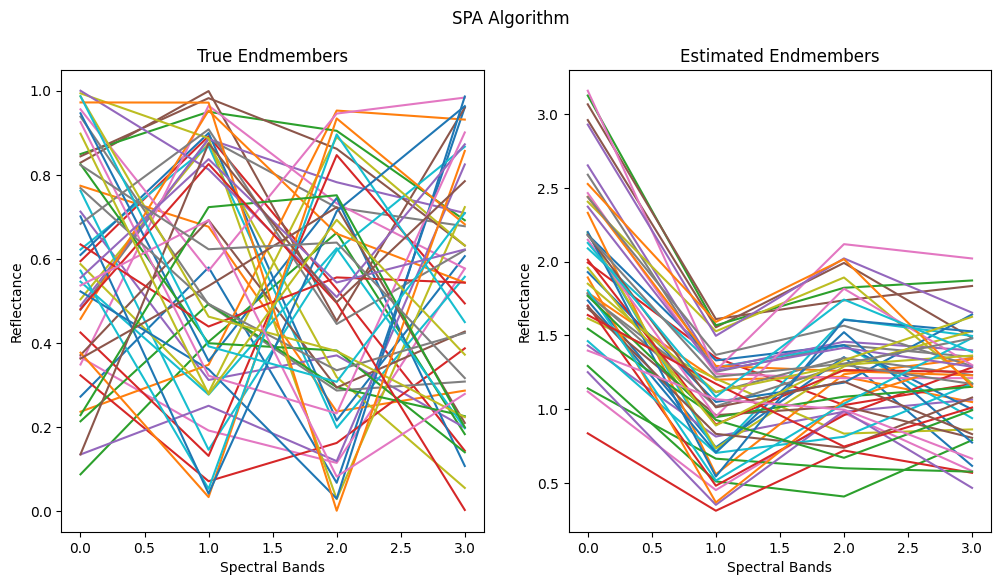

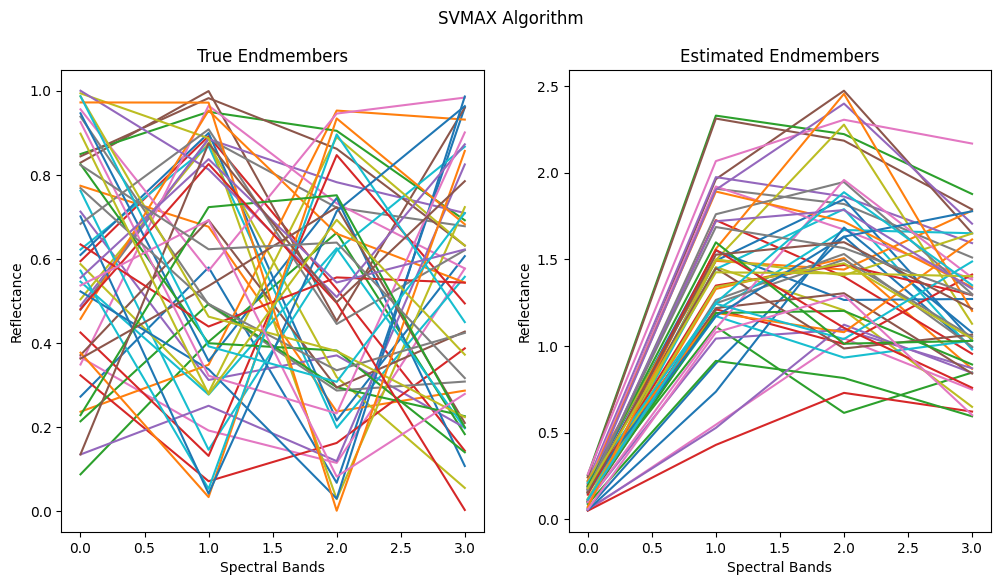

In [14]:
import torch
import matplotlib.pyplot as plt

def generate_synthetic_data(M, L, N, noise_level=0.01):
    """
    Generate synthetic data for testing the algorithms.

    Args:
        M (int): Number of spectral bands.
        L (int): Number of samples.
        N (int): Number of endmembers.
        noise_level (float): Amount of noise to add to the data.

    Returns:
        Y (torch.Tensor): Generated data of shape (M, L).
        A_true (torch.Tensor): True endmembers of shape (M, N).
    """
    A_true = torch.rand(M, N)
    S = torch.rand(N, L)
    Y = A_true @ S + noise_level * torch.randn(M, L)  # Add noise to the synthetic data
    return Y, A_true

def plot_results(Y, A_true, A_est, title):
    """
    Plot the true endmembers and the estimated endmembers for comparison.

    Args:
        Y (torch.Tensor): Input data matrix.
        A_true (torch.Tensor): True endmember matrix.
        A_est (torch.Tensor): Estimated endmember matrix.
        title (str): Plot title.
    """
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].plot(A_true.cpu().T)
    axs[0].set_title("True Endmembers")
    axs[0].set_xlabel("Spectral Bands")
    axs[0].set_ylabel("Reflectance")

    axs[1].plot(A_est.cpu().T)
    axs[1].set_title("Estimated Endmembers")
    axs[1].set_xlabel("Spectral Bands")
    axs[1].set_ylabel("Reflectance")

    plt.suptitle(title)
    plt.show()

def main():
    # Parameters
    M = 50  # Number of spectral bands
    L = 1000  # Number of samples
    N = 4  # Number of endmembers

    # Generate synthetic data
    Y, A_true = generate_synthetic_data(M, L, N, noise_level=0.02)

    # Apply SPA
    A_est_spa = SPA(Y, N)
    plot_results(Y, A_true, A_est_spa, "SPA Algorithm")

    # Apply SVMAX
    A_est_svmax = SVMAX(Y, N)
    plot_results(Y, A_true, A_est_svmax, "SVMAX Algorithm")

if __name__ == "__main__":
    main()